# Setup

In [432]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
import seaborn as sns
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from scipy import stats

dl = DataLib("SignalData")

plt.style.use("seaborn")

In [433]:
# Pull all the necessary dataframes to avoid duplicate code. 
bri = dl.pull("BondRetIdx/LocalFX")
LongRates = dl.pull("LongRates")
ShortRates = dl.pull("ShortRates")
EquityPrices = dl.pull("EquityPrices")
M1 = dl.pull("M1/inUSD")
M2 = dl.pull("M2/inUSD")
M3 = dl.pull("M3/inUSD")
CurrAcctNom = dl.pull("CurrAcctNom/inUSD")
CurrAcctPctGDP = dl.pull("CurrAcctPctGDP")
nGDP = dl.pull("GDP/Nominal")
rGDP = dl.pull("GDP/Real")
nFxTrdWts = dl.pull("fxTrdWts/Nominal")
rFxTrdWts = dl.pull("fxTrdWts/Real")
fxVsUSD = dl.pull("fxVsUSD")
core_cpi = dl.pull("CoreCPI/SA")
rfRates = dl.pull("RiskfreeRates")

In [434]:
# Constants. 
WORKDAYS_IN_MONTH=21
WORKDAYS_IN_YEAR=261
QUARTERS_IN_YEAR=4
COUNTRIES=[
    'USA', 'AUS', 'JPN', 'CAN', 'CHE', 'GBR', 'ESP', 'FRA', 'ITA', 'DEU'
]

# Get z-scores

In [435]:
GDP_zscore = dl.pull('GDP_zscore')
premium_zscore = dl.pull('premium_zscore')
height_zscore = dl.pull("height_zscore")

# Returns: GDP indicator

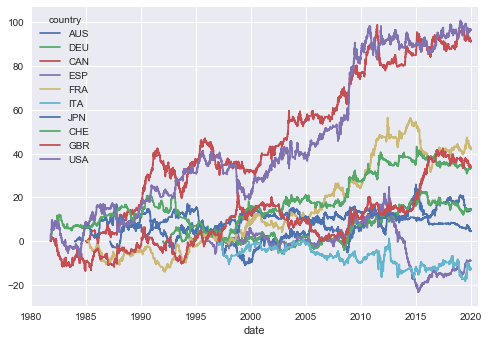

<function matplotlib.pyplot.show(*args, **kw)>

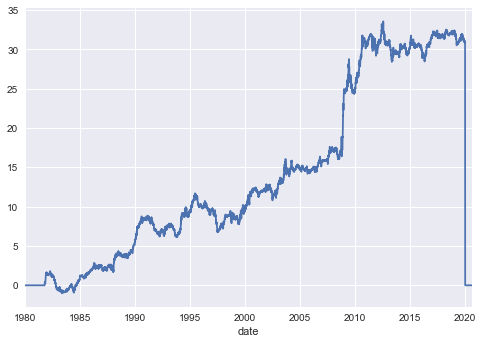

In [436]:
signal = GDP_zscore.clip(upper=1.5, lower=-1.5) / 1.5
signal = signal[signal.index < '2020-01-01']
signal_gdp = signal.resample('B').ffill()

# Calculate cumulative returns. 
bri_chg = bri.pct_change()
returns_gdp = (bri_chg.shift(-1) * signal_gdp)       
cumul_returns_gdp = ((returns_gdp + 1).cumprod() - 1) * 100

# Plot the returns for each country. 
cumul_returns_gdp.plot()
plt.show()

# Plot the total returns.
(cumul_returns_gdp * 0.1).sum(axis=1).plot()
plt.show

# Returns: Bond Premium indicator

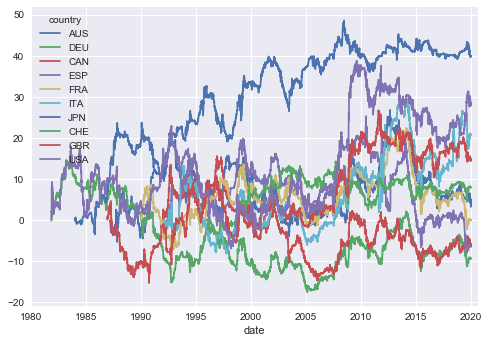

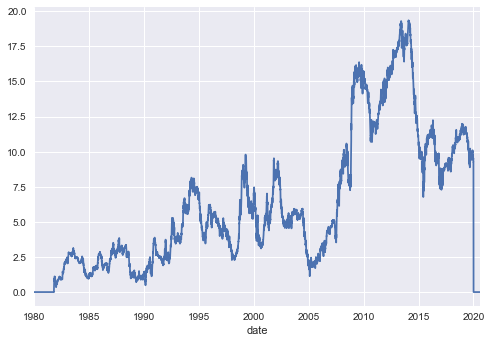

In [437]:
signal = premium_zscore.clip(upper=2, lower=-2) / 2
signal = signal[signal.index < '2020-01-01']
signal_premium = signal.resample('B').ffill()

# Calculate cumulative returns. 
bri_chg = bri.pct_change()
returns_premium = (bri_chg.shift(-1) * signal_premium)       
cumul_returns_premium = ((returns_premium + 1).cumprod() - 1) * 100

# Plot the returns. 
cumul_returns_premium.plot()
plt.show()

# Plot the total returns (assume equal amount of capital in each market).
(cumul_returns_premium * 0.1).sum(axis=1).plot()
plt.show()

# Returns: Curve height indicator

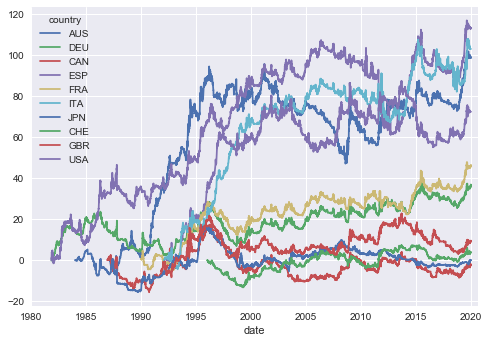

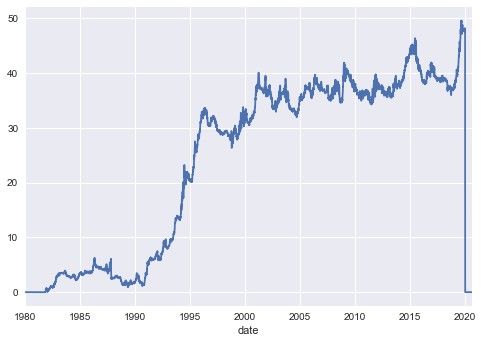

In [438]:
signal = height_zscore.clip(upper=2, lower=-2) / 2
signal = signal[signal.index < '2020-01-01']
signal_height = signal.resample('B').ffill()

# Calculate cumulative returns. 
bri_chg = bri.pct_change()
returns_height = (bri_chg.shift(-1) * signal_height)       
cumul_returns_height = ((returns_height + 1).cumprod() - 1) * 100

# Plot the returns for each country. 
cumul_returns_height.plot()
plt.show()

# Plot the total returns (assume equal amount of capital in each market).
(cumul_returns_height * 0.1).sum(axis=1).plot()
plt.show()

# Correlation between return streams

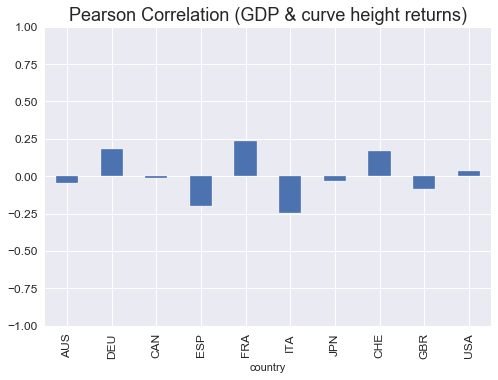

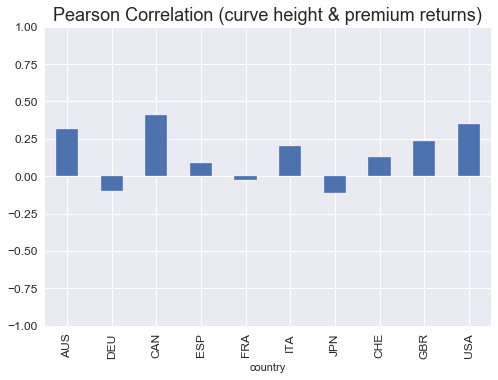

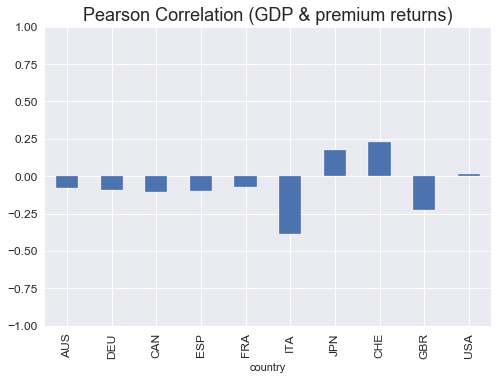

In [461]:
ax = returns_height.corrwith(returns_gdp).plot.bar(title='Pearson Correlation (GDP & curve height returns)', fontsize=12)
ax.title.set_size(18)
plt.ylim(-1, 1)
plt.show()

ax = returns_height.corrwith(returns_premium).plot.bar(title='Pearson Correlation (curve height & premium returns)', fontsize=12)
plt.ylim(-1, 1)
ax.title.set_size(18)
plt.show()

ax = returns_gdp.corrwith(returns_premium).plot.bar(title='Pearson Correlation (GDP & premium returns)', fontsize=12)
ax.title.set_size(18)
plt.ylim(-1, 1)
plt.show()

# Returns in risk-adjusted space

In [440]:
def get_risk_adjusted_returns():

    # Convert from monthly to daily rf rates.
    series = rfRates / 100
    series = series.resample('B').ffill()
    series = (series + 1) ** (1 / WORKDAYS_IN_YEAR) - 1
    series = series.loc[bri.index]
    
    # Convert this series to a dataframe.
    rf_rates = bri.copy()
    for country in rf_rates.columns.values: 
        rf_rates[country] = series
        
    # Subtract the rates from the change in bond returns. 
    return bri.pct_change() - rf_rates

In [441]:
'''
    Return the Sharpe ratio given a signal.
'''
def get_sharpe(signal): 
    
    # Get the returns of this strategy
    risk_adjusted_returns = get_risk_adjusted_returns()
    returns = signal * risk_adjusted_returns.shift(-1)
    
    gmean = stats.gmean(1 + returns.sum(axis=1))
    annualized_return = (gmean ** 261) - 1
    risk = returns.sum(axis=1).std() * np.sqrt(261)
    
    return annualized_return/risk

'''
    Return the Sharpe ratio given a signal for a given country.
'''
def get_country_sharpe(signal, country): 
    
    # Get the returns of this strategy
    risk_adjusted_returns = get_risk_adjusted_returns()
    returns = signal * risk_adjusted_returns.shift(-1)
    
    gmean = stats.gmean((1 + returns[country]).dropna())
    annualized_return = (gmean ** 261) - 1
    risk = returns[country].std() * np.sqrt(261)
    
    return annualized_return/risk

Returns for the two indicators in absolute space:

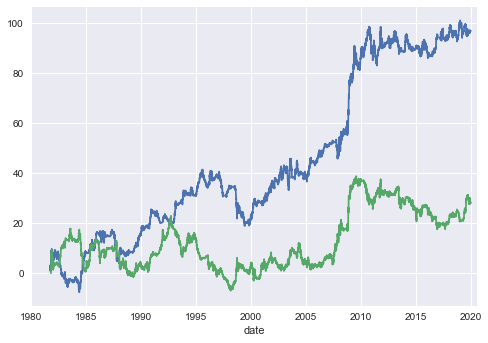

In [442]:
cumul_returns_gdp['USA'].plot()
cumul_returns_premium['USA'].plot()

Let's normalize by the volatility of each return stream, and then compare the two. 

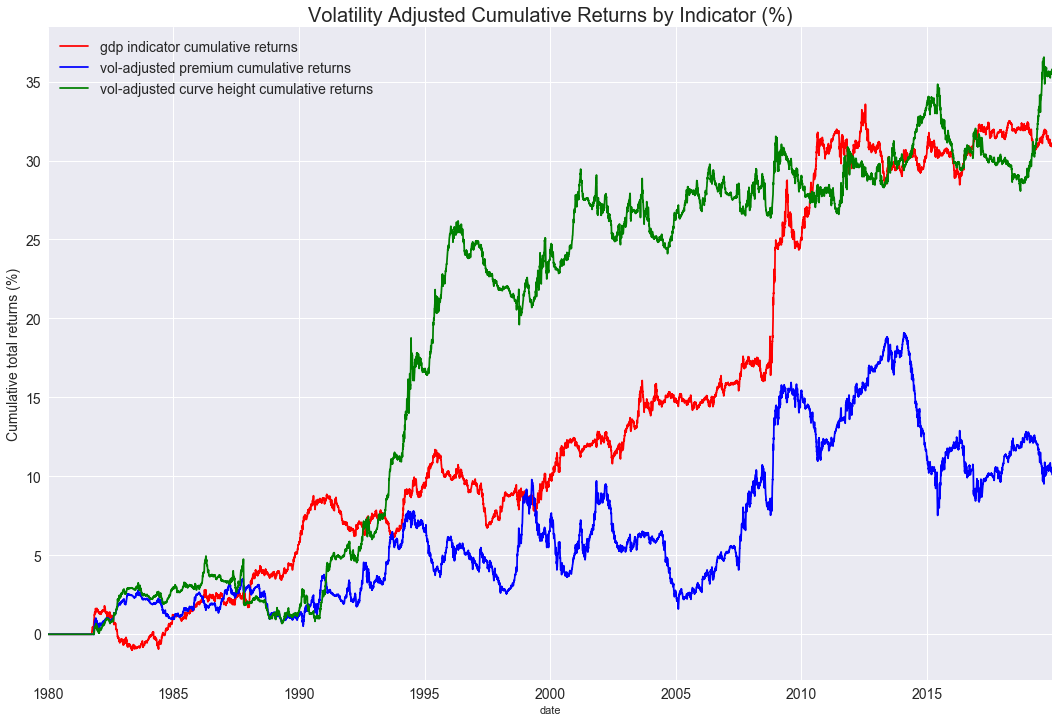

In [477]:
# Get the volatility for both portfolios. 
vol_gdp = returns_gdp.std(axis=0) * 100
vol_premium = returns_premium.std(axis=0) * 100
vol_height = returns_height.std(axis=0) * 100

fig, ax = plt.subplots(figsize=(18,12))

# Plot the returns for our GDP indicator.
cumul_returns = (cumul_returns_gdp * 0.1).sum(axis=1)
cumul_returns = cumul_returns[cumul_returns.index < '2020-01-01']
cumul_returns.plot(color='red', label='gdp indicator cumulative returns')

# Plot the volatility-adjusted returns for premium indicator.
returns_premium_voladj = returns_premium.divide(vol_premium, axis=1)
returns_premium_voladj = returns_premium_voladj.multiply(vol_gdp, axis=1)
cumul_returns = ((0.1*returns_premium_voladj + 1).cumprod() - 1) * 100
cumul_returns_premium_voladj = cumul_returns[cumul_returns.index < '2020-01-01']
cumul_returns_premium_voladj.sum(axis=1).plot(color='blue', label='vol-adjusted premium cumulative returns')
plt.legend(loc=0)

# Plot the volatility-adjusted returns for curve height indicator.
returns_height_voladj = returns_height.divide(vol_height, axis=1)
returns_height_voladj = returns_height_voladj.multiply(vol_gdp, axis=1)
cumul_returns = ((0.1*returns_height_voladj + 1).cumprod() - 1) * 100
cumul_returns_height_voladj = cumul_returns[cumul_returns.index < '2020-01-01']
ax = cumul_returns_height_voladj.sum(axis=1).plot(color='green', label='vol-adjusted curve height cumulative returns', fontsize=14)
ax.set_ylabel("Cumulative total returns (%)", fontsize=14)
plt.legend(loc=2, prop={'size': 14})
plt.title('Volatility Adjusted Cumulative Returns by Indicator (%)')
ax.title.set_size(20)
plt.show()

In [479]:
sharpe_premium = get_sharpe(signal_premium)
sharpe_gdp = get_sharpe(signal_gdp)
sharpe_height = get_sharpe(signal_height)
sharpes = pd.DataFrame([sharpe_premium, sharpe_gdp, sharpe_height], columns=['Sharpe Ratio'], index=['Bond Premium', 'Change in Real GDP', 'Curve Height'])
sharpes.index.name = "Indicator"
sharpes

,Sharpe Ratio
Indicator,
Bond Premium,0.045384
Change in Real GDP,0.472150
Curve Height,0.366802


Look at Sharpe ratios by country for our GDP indicator. 

In [398]:
for country in COUNTRIES: 
    print('{} GDP sharpe'.format(country), get_country_sharpe(signal_gdp, country))

USA GDP sharpe 0.38424407138128924
AUS GDP sharpe 0.08287611721095935
JPN GDP sharpe -0.002493618094223048
CAN GDP sharpe 0.4396913133322921
CHE GDP sharpe 0.2437149270880105
GBR GDP sharpe 0.17516789375540937
ESP GDP sharpe -0.10406379690362459
FRA GDP sharpe 0.31615988871380396
ITA GDP sharpe -0.10868009751255611
DEU GDP sharpe 0.13652635072383512


# Combining indicators

In [480]:
def plot_returns(signal, title1, title2): 
    
    # Ensure the signal is sampled every business day. 
    signal = signal.resample('B').ffill()

    # Calculate cumulative returns. 
    bri_chg = bri.pct_change()
    returns = (bri_chg.shift(-1) * signal)  
    returns = returns.loc[signal.index]
    cumul_returns = ((returns + 1).cumprod() - 1) * 100

    # Plot the returns for each country. 
    cumul_returns.plot(title=title1, figsize=(12,12))
    plt.show()

    # Plot the total returns (assume equal amount of capital in each market).
    (cumul_returns * 0.1).sum(axis=1).plot(title=title2, figsize=(12,12))
    plt.show()

In [481]:
# Returns a signal based on a decision scheme to combine the given indicators.
def combine(indicators): 
    signal = pd.DataFrame(indicators[0], index=indicators[0].index)
    
    for country in COUNTRIES:
        for date in signal.index: 
            values = [ind[country].loc[date] for ind in indicators]
            values.sort(key=lambda x: abs(x), reverse=True)
            if values[0] * values[1] > 0: 
                signal[country].loc[date] = values[0]
            else: 
                signal[country].loc[date] = (1/2) * values[0] + (1/2) * values[1]
    
    return signal

In [482]:
combined = combine([signal_gdp, signal_premium, signal_height])

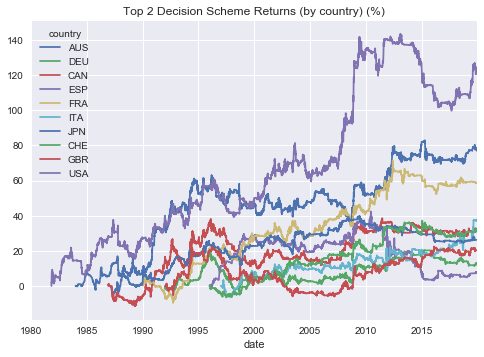

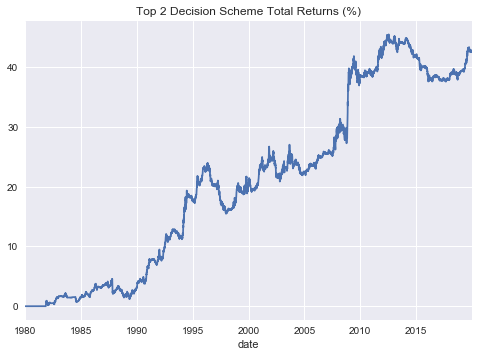

0.47214972965924823

In [447]:
plot_returns(combined, "Top 2 Decision Scheme Returns (by country) (%)", "Top 2 Decision Scheme Total Returns (%)")
get_sharpe(combined)

Let's begin with a naive equal weighting of three indicators. 

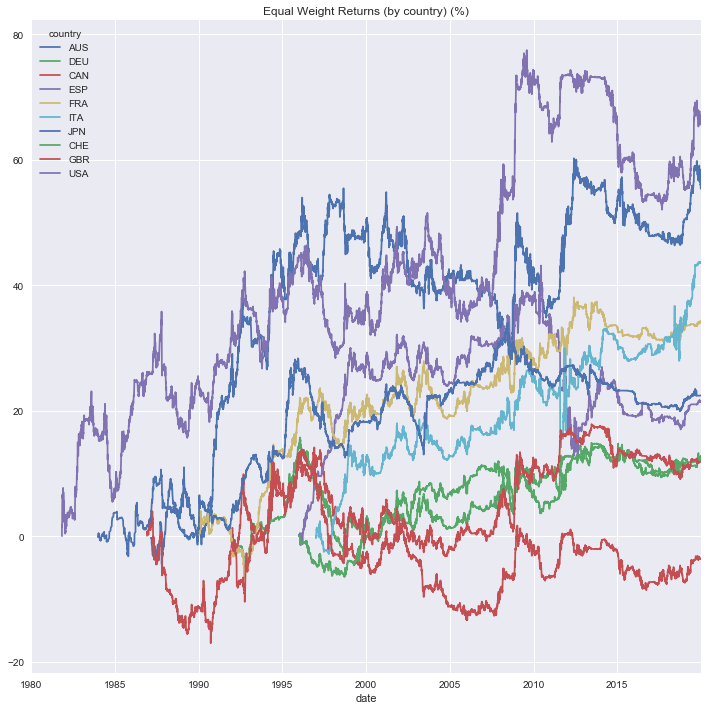

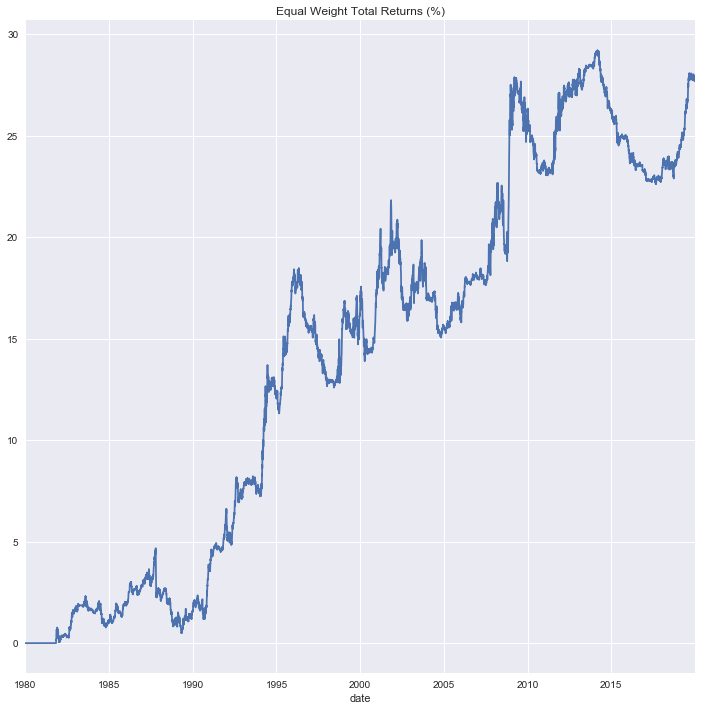

0.33182532601893905

In [483]:
signal = (1/3) * signal_gdp + (1/3) * signal_premium + (1/3) * signal_height
plot_returns(signal, "Equal Weight Returns (by country) (%)", "Equal Weight Total Returns (%)")
get_sharpe(signal)